## MUSE - Machine Translation


### Tutorial Topics
- MUSE (cross lingual word embedding model) 

### Software Requirements
- Python (>=3.6)
- Jupyter (latest)

# [MUSE: Multilingual Unsupervised and Supervised Embeddings](https://research.fb.com/downloads/muse-multilingual-unsupervised-and-supervised-embeddings/)

MUSE is a Python library for multilingual word embeddings, whose goal is to provide the community with:

* state-of-the-art multilingual word embeddings based on [fastText](https://github.com/facebookresearch/fastText)
* large-scale high-quality bilingual dictionaries for training and evaluation

MUSE includes two methods, one `supervised` that uses a bilingual dictionary or identical character strings, and one `unsupervised` that does not use any parallel data (see paper [Word Translation without Parallel Data](https://arxiv.org/pdf/1710.04087.pdf) for more details).

![](https://raw.githubusercontent.com/mt-upc/blog/main/assets/2e_MajorBreakthroughs_UnsupervisedNMT/cle.png?raw=true)

You can align any bilingual word embeddings using MUSE package. You can explore the training process [here](https://github.com/facebookresearch/MUSE).

### 1. Training MUSE

For training MUSE unsupervised models, you need to run the following setup cells, upload the europarl corpora you want to create alignments of, and run training code in the appropriate cells. 

NOTE SUGGEST RUNNING THIS IN GPU MODE (Runtime --> Change Runtime Type --> GPU) While Fasttext is CPU only, MUSE is very slow on CPU.

Total time to train everything should be ~1.5 hrs on GPU. 

In [18]:
import torch

In [19]:
!git clone https://github.com/facebookresearch/MUSE.git

Cloning into 'MUSE'...
remote: Enumerating objects: 239, done.
remote: Total 239 (delta 0), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (239/239), 215.77 KiB | 2.32 MiB/s, done.
Resolving deltas: 100% (136/136), done.


Download the evaluation data for MUSE

Takes a few minutes to download

[NOTE: We ran into some issues getting MUSE to correctly use the evaluation data. It should be possible to skip this cell (with no impact on training quality) if you follow the note about commenting a line in the evaluator.py file.]

In [ ]:
!cd ./MUSE/data/; chmod +x get_evaluation.sh
!cd ./MUSE/; ./data/get_evaluation.sh

In [ ]:
#get fasText 
! wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
! unzip v0.9.2.zip
! cd fastText-0.9.2; make


In [ ]:
#get europarl fr_en
!wget https://www.statmt.org/europarl/v7/fr-en.tgz

In [ ]:
#unpack
!tar -xvzf fr-en.tgz

##### Run your training code:

To run the training scripts you will need to prefix the command with a ! to run it as if it was a linux terminal.

With the Europarl corpora we will build the fasText alignments  (see below). Once embeddings are created, we'll then feed them to MUSE. 

fastText does not need GPU to run and takes about 30 minutes each, you can run it in a CPU only notebook, save the files that are created (MUSE/en.vec MUSE/fr.vec) and then move them over to a GPU notebook for running MUSE, if you are concerned about your GPU quota.


In [ ]:
### FastText Here 
!./fastText-0.9.2/fasttext skipgram -input europarl-v7.fr-en.en -output MUSE/en 
!./fastText-0.9.2/fasttext skipgram -input europarl-v7.fr-en.fr -output MUSE/fr


In [ ]:
#https://github.com/facebookresearch/MUSE/blob/master/demo.ipynb
import io
import numpy as np

def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

## modified this to return a result list
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        result.append((scores[idx], tgt_id2word[idx]))
    return result

In [ ]:
# load english and french word embeddings
MUSE_PATH = "MUSE"
en_embeddings, en_id2word, en_word2id = load_vec(MUSE_PATH + "/en.vec", nmax=50000)
fr_embeddings, fr_id2word, fr_word2id = load_vec(MUSE_PATH + "/fr.vec", nmax=50000)

You can use the get_nn function as follows (where K is the number of results, feel free to increase).

In [26]:
# FAISS is a tool to speed training of some facebook models, this is how you can import it.
!apt install libomp-dev
!pip install faiss-gpu
import faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (1:10.0-50~exp1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now we are going to run MUSE.
Note: We found an issues with running the eval parts of the training, to get around this comment out line 217 in /MUSE/src/evaluation/evaluator.py:
 self.word_translation(to_log)

#### Training time may take around 90 minutes on GPU, plan accordingly.

In [ ]:
en_embeddings, en_id2word, en_word2id = load_vec("path/to/en_vectors.txt", nmax=50000)
fr_embeddings, fr_id2word, fr_word2id = load_vec("path/to/fr_vectors.txt", nmax=50000)

### 2. Use Trained MUSE

MUSE released their fastText embeddings that have been aligned in a common space [here](https://github.com/facebookresearch/MUSE#download). Let us download [English](https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec) and [Spanish](https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.es.vec) word embeddings.

In the rest of this tutorial, we will focus on loading these embeddings, identify words most similar to a given word in the same language and the other language.

In [2]:
!wget https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec
!wget https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.es.vec


--2023-03-18 13:44:16--  https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628614720 (599M) [text/plain]
Saving to: ‘wiki.multi.en.vec’

wiki.multi.en.vec   100%[===================>] 599.49M  66.2MB/s    in 9.6s    

2023-03-18 13:44:27 (62.8 MB/s) - ‘wiki.multi.en.vec’ saved [628614720/628614720]

--2023-03-18 13:44:27--  https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.es.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628826336 (600M) [text/plain]
Saving to: ‘wiki.multi.es.vec’

wiki.multi.es.vec   100%

##### Required packages

In [3]:
import io
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

**Create a function that loads a word vector file into memory and returns word embeddings, identifier to word and word to identifier mapping**

In [4]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f) # skips the first line
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

Load both english and spanish word embeddings (max. $50K$ in each language):

In [5]:
src_path = './wiki.multi.en.vec'
tgt_path = './wiki.multi.es.vec'
nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

We can check the shapes of english and spanish embeddings:

In [6]:
print("Shape of English word embeddings = ", src_embeddings.shape)
print("Shape of Spanish word embeddings = ", tgt_embeddings.shape)

Shape of English word embeddings =  (50000, 300)
Shape of Spanish word embeddings =  (50000, 300)


**We will use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) to measure the similarity between two word embedding vectors. The formula of cos similarity is:**

$similarity = cos(\theta) = \frac{A \cdot B}{||A|| ||B||} = \frac{\sum_{i=1}^{d} A_iB_i}{\sqrt{\sum_{i=1}^{d} A^2_i}\sqrt{\sum_{i=1}^{d} B^2_i}}$

**Now, we assume A is the vector of `cat` in English and B is the vector of `dog` in English.**

In [7]:
A = src_embeddings[src_word2id['cat']] # word embedding of 'cat' in English word embedding space
B = src_embeddings[src_word2id['dog']] # word embedding of 'dog' in English word embedding space
print("Shape of 'cat' word embedding = ", A.shape)
print("Shape of 'dog' word embedding = ", B.shape)
cos_sim = np.dot(A, B) / np.linalg.norm(A) * np.linalg.norm(B)
print("cosine similarity (cat, dog) = ",cos_sim)

Shape of 'cat' word embedding =  (300,)
Shape of 'dog' word embedding =  (300,)
cosine similarity (cat, dog) =  0.638051699007895


**Alternatively, we can use the `cosine_similarity` function from sklearn.**

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
#  the shape of A and B must be (n_samples_X, n_features). Hence we reshape the A and B vectors.
print("cosine similarity (cat, dog) = ", cosine_similarity(A.reshape(1, -1), B.reshape(1, -1))) 

cosine similarity (cat, dog) =  [[0.63805158]]


**Let's print the 5 nearest neighbors of the word `cat` in English word embedding space.**

In [9]:
# get all similarity scores between cat and all the tokens in English vocabulary. 
all_scores = cosine_similarity(src_embeddings, A.reshape(1, -1))
print("Similarity of word cat with all words in English vocabulary (shape) = ", all_scores.shape)

# reshape (num_vocabulary, 1) to (num_vocabulary)
all_scores = np.squeeze(all_scores,axis=1)
print("Similarity of word cat with all words in English vocabulary (shape after removing extra dimension) = ", all_scores.shape)

# get indices of the 5 nearest neighbors
top5_ind = all_scores.argsort()[-5:][::-1]
print("Word indices of five nearest neighbors of word cat = ", top5_ind)

# convert the indices to actual tokens
print("Similarity - word (word id)")
for i, idx in enumerate(top5_ind):
    print('%.4f - %s (%d)' % (all_scores[idx], src_id2word[idx], idx))

Similarity of word cat with all words in English vocabulary (shape) =  (50000, 1)
Similarity of word cat with all words in English vocabulary (shape after removing extra dimension) =  (50000,)
Word indices of five nearest neighbors of word cat =  [ 2570  4939 25570  2344 36108]
Similarity - word (word id)
1.0000 - cat (2570)
0.7322 - cats (4939)
0.6453 - kitten (25570)
0.6381 - dog (2344)
0.6218 - kittens (36108)


**Let's buid a function to get the $n$ nearest neighbors of given word.**

In [10]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    # create to map word to index
    word2id = {v: k for k, v in src_id2word.items()}
    # get the word embedding of give word 
    word_emb = src_emb[word2id[word]]
    # get all similarity scores between given word and all the tokens in target vocabulary. 
    scores = np.squeeze(cosine_similarity(tgt_emb, word_emb.reshape(1, -1)),axis=1)
    # get indices of the n nearest neighbors
    k_best = scores.argsort()[-K:][::-1]
    # convert the indices to actual tokens
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

**Let's print nearest neighbors of the English word *cat* in the English word embedding space again using *get_nn* function.**

In [11]:
# printing nearest neighbors in the source space (English), results will be identical to the previous query
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "cat":
1.0000 - cat
0.7322 - cats
0.6453 - kitten
0.6381 - dog
0.6218 - kittens


**Let's print nearest neighbors of the English word *king* in the English word embedding space again using *get_nn* function.**

In [12]:
# printing nearest neighbors in the source space (English)
src_word = 'king'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "king":
1.0000 - king
0.6762 - kings
0.6493 - queen
0.6260 - monarch
0.5978 - kingship


**Let's print nearest neighbors of the English word *cat* in the Spanish word embedding space again using *get_nn* function.**

Note that the fourth and fifth argument to the function should be Spanish identifier to word mapping and Spanish word embeddings respectively.

In [13]:
# printing nearest neighbors of a word in source language (English) in the target space (Spanish)
# if the quality of the embeddings is good, this query can provide the translation for the word in the target language
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "cat":
0.6165 - gato
0.5401 - perro
0.4849 - conejo
0.4839 - gorila
0.4746 - felino


**Let's print nearest neighbors of the English word *king* in the Spanish word embedding space again using *get_nn* function.**

In [14]:
# printing nearest neighbors in the target space (Spanish)
src_word = 'king'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "king":
0.8047 - rey
0.6728 - monarca
0.6187 - reina
0.5814 - reinar
0.5755 - reyes


### 3. Visualize multilingual embeddings

In order to visualize the word embeddings in 2 dimensional space, we will use PCA to map word embeddings from 300 dimensions to 2 dimensions.

Let's fit PCA on the concatenation of English and Spanish word embeddings.

In [15]:
from sklearn.decomposition import PCA
# instantiate a PCA object which includes two components
pca = PCA(n_components=2, whiten=True)
# use PCA object on src_embeddings and tgt_embeddings
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
# how much variance of orignial embeddings (300 dimensions) is explained in PCA components (2 dimensions)?
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.06


**Let's use matplotlib machinery to build a function `plot_similar_word` that takes a list of English and Spanish words and plot them in a single multilingual word embedding space.**

In [16]:
import matplotlib.pyplot as plt

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

Let's pick some sample English and Spanish words (that are present in our vocabulary) and call the *plot_similar_word* function to create the visualization of all the words in a single multilingual word embedding space.

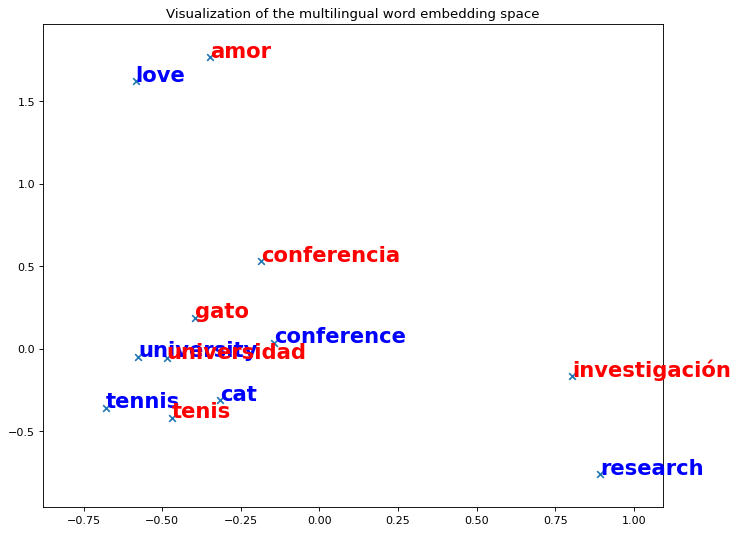

In [17]:
# get 5 random input words
src_words = ['university', 'love', 'cat', 'tennis', 'research', 'conference']
tgt_words = ['universidad', 'amor', 'gato', u'tenis',  u'investigación', 'conferencia']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

### 4. Practice

4.1 Cosine Similarity

Cosine similarity is used fairly frequently in NLP.

$similarity = cos(\theta) = \frac{A \cdot B}{||A|| ||B||} = \frac{\sum_{i=1}^{d} A_iB_i}{\sqrt{\sum_{i=1}^{d} A^2_i}\sqrt{\sum_{i=1}^{d} B^2_i}}$

Using the following two tensors (of a dim=3 embedding) show **by hand** how you would calculate the cosine similarity between these two vectors.

A = [ 0.1010, -1.1388, -0.7991]

B = [ 0.5083, -0.2255,  1.9037]


[Answer Goes Here]

4.2 Plotting Aligned Embeddings

For the following set of words: "excessively", "Minutes", "citizens", "standards", and "disaster" create a 2D diagram showing the words in vector space alongside their French closest 'equivalents'.

In [ ]:
# Answer Goes Here

4.3 Train MUSE from scratch

Use the code in Section 1 to train MUSE from scratch.

# Reference 
* https://medium.com/@weGotlieb/using-giza-for-bilingual-sentence-alignment-8b2dc828a04d
* http://www.statmt.org/moses/?n=Moses.Baseline
* https://www.aclweb.org/anthology/E99-1010/
* http://masatohagiwara.net/using-giza-to-obtain-word-alignment-between-bilingual-sentences.html
* https://okapiframework.org/wiki/index.php/GIZA%2B%2B_Installation_and_Running_Tutorial
* https://www.ijert.org/research/word-alignment-using-giza-and-cygwin-on-windows-IJERTV2IS50775.pdf
* https://github.com/facebookresearch/MUSE/blob/master/demo.ipynb